In [1]:
import h5py
import psana
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import  rotate
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit,minimize
from scipy import signal
import multiprocessing
import os
from functools import partial
import time
import sys
import argparse
from datetime import datetime
import tempfile
import XSpect.XSpect_Analysis
import XSpect.XSpect_Controller
import XSpect.XSpect_Visualization


Wrote these new function to do quick background subtraction.

In [2]:
def apply_weights(length, peaks):
    """
    Apply weights to the data length, setting weights to nearly zero for the peak regions.
    :param length: Integer, length of the data array
    :param peaks: List of tuples with (start_index, end_index)
    :return: Weights array
    """
    weights = np.ones(length)
    for start, end in peaks:
        weights[start:end] = 0.001  
    return weights

def fit_and_subtract_polynomial(data, degree, peaks):
    """
    Fit a polynomial to the data excluding masked peaks by adjusting weights, and subtract it.
    :param data: 1D numpy array
    :param degree: Degree of the polynomial
    :param peaks: List of tuples with (start_index, end_index) to mask
    :return: 1D array with polynomial subtracted
    """
    weights = apply_weights(len(data), peaks)
    x = np.arange(len(data))
    
    coeffs = np.polyfit(x, data, degree, w=weights)
    poly = np.poly1d(coeffs)

    fitted_values = poly(x)
    
    corrected_data = data - fitted_values
    
    return corrected_data, fitted_values

## Viewing Static XES Spectra

Importing data for Cu ROI's

Processing: 100%|██████████| 106/106 [01:34<00:00,  1.12Shot_Batch/s]


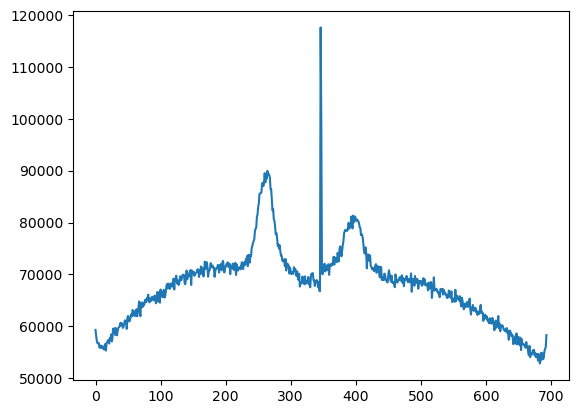

In [3]:
#ds1_ROI1 in this case is the Cu ROI of interest for a particular dataset of runs 253-274 (ds)
xes_experiment = XSpect.XSpect_Analysis.spectroscopy_experiment(hutch='mfx',experiment_id='mfxl1045123',lcls_run=23)
xes=XSpect.XSpect_Controller.XESBatchAnalysisRotation()
xes.key_epix=['epix_1/ROI_0_area']
#xes.set_key_aliases(keys,names)
#xes.import_roi=[[0,100]]
xes.rois=[[100,130]]
xes.adu_cutoff=3.0
xes.angle=0
xes.transpose=True
xes.run_parser(['253-274'])
#xes.append_arbitrary_filtering(xes_experiment,basepath='filter_indices')
#xes.arbitrary_filter=True
xes.verbose=False

start=time.time()
xes.primary_analysis_parallel_range(4,xes_experiment,method=xes.primary_analysis_static,increment=2000,verbose=False)
end=time.time()
v=XSpect.XSpect_Visualization.XESVisualization()
v.combine_static_spectra(xes_analysis=xes,xes_key='epix_ROI_1_summed')
v.summed_xes=v.summed_xes[5:-5]
plt.plot(v.summed_xes)
ds1_ROI1=v.summed_xes

Processing: 100%|██████████| 66/66 [00:52<00:00,  1.26Shot_Batch/s]


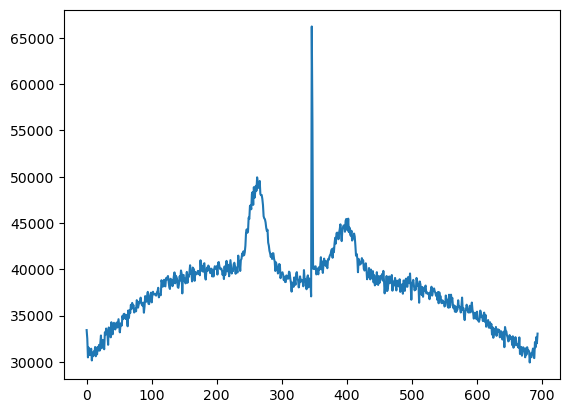

In [16]:
xes_experiment = XSpect.XSpect_Analysis.spectroscopy_experiment(hutch='mfx',experiment_id='mfxl1045123',lcls_run=23)
xes=XSpect.XSpect_Controller.XESBatchAnalysisRotation()
xes.key_epix=['epix_1/ROI_0_area']
#xes.set_key_aliases(keys,names)
#xes.import_roi=[[0,100]]
xes.rois=[[100,130]]
xes.adu_cutoff=3.0
xes.angle=0
xes.transpose=True
xes.run_parser(['287-300'])
#xes.append_arbitrary_filtering(xes_experiment,basepath='filter_indices')
#xes.arbitrary_filter=True
xes.verbose=False

start=time.time()
xes.primary_analysis_parallel_range(4,xes_experiment,method=xes.primary_analysis_static,increment=2000,verbose=False)
end=time.time()
v=XSpect.XSpect_Visualization.XESVisualization()
v.combine_static_spectra(xes_analysis=xes,xes_key='epix_ROI_1_summed')
v.summed_xes=v.summed_xes[5:-5]
plt.plot(v.summed_xes)
ds2_ROI1=v.summed_xes

Background correction

Text(0.5, 1.0, 'mfxl1045123; Runs 253-274; Cu-background sub, O2reaction 450 ms; Unfiltered.')

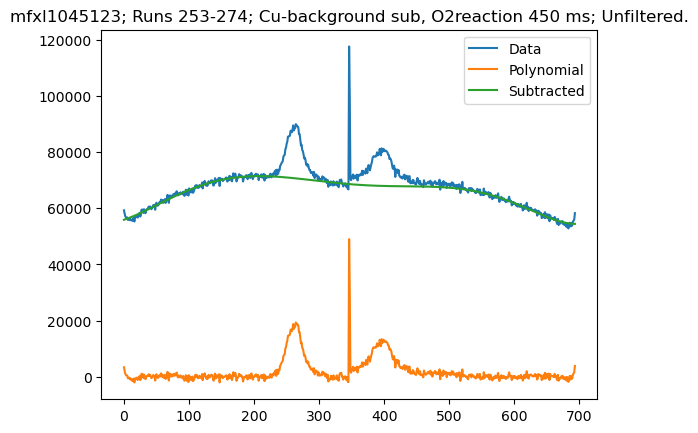

In [17]:
ds1_ROI1_corr,ds1_ROI1_fit=fit_and_subtract_polynomial(ds1_ROI1,7,[(200,525)])
plt.plot(ds1_ROI1)
plt.plot(ds1_ROI1_corr)
plt.plot(ds1_ROI1_fit)
plt.legend(['Data','Polynomial','Subtracted'])
plt.title('mfxl1045123; Runs 253-274; Cu-background sub, O2reaction 450 ms; Unfiltered.')

Text(0.5, 1.0, 'mfxl1045123; Runs 287-296; Cu-background sub, o2reaction_5mm; Unfiltered.')

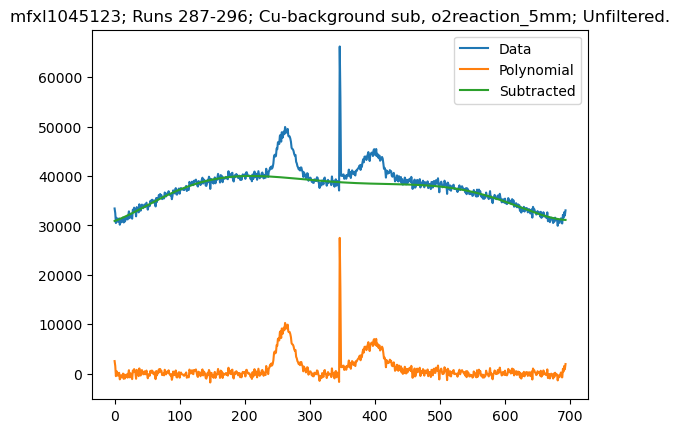

In [18]:
ds2_ROI1_corr,ds2_ROI1_fit=fit_and_subtract_polynomial(ds2_ROI1,6,[(205,525)])
plt.plot(ds2_ROI1)
plt.plot(ds2_ROI1_corr)
plt.plot(ds2_ROI1_fit)
plt.legend(['Data','Polynomial','Subtracted'])
plt.title('mfxl1045123; Runs 287-296; Cu-background sub, o2reaction_5mm; Unfiltered.')

Normalization of background corrected data

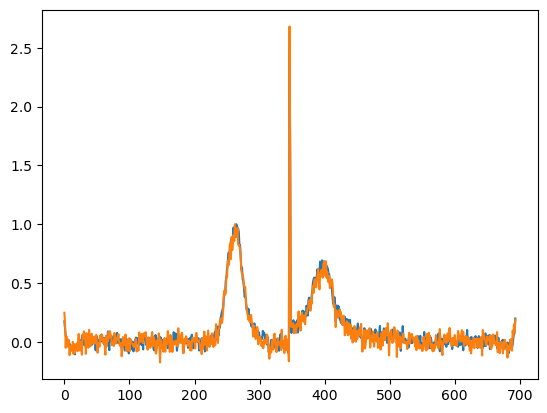

In [19]:

ds1_ROI1_corr_n = ds1_ROI1_corr/np.max(ds1_ROI1_corr[200:300])
ds2_ROI1_corr_n = ds2_ROI1_corr/np.max(ds2_ROI1_corr[200:300])
plt.plot(ds1_ROI1_corr_n)
plt.plot(ds2_ROI1_corr_n)

Comparison background corrected normalized data of different scans

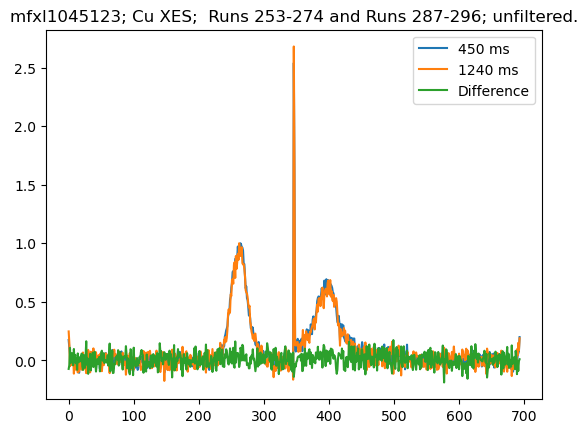

In [20]:
plt.plot(ds1_ROI1_corr_n)
plt.plot(ds2_ROI1_corr_n)

diff_ROI1 = ds1_ROI1_corr_n-ds2_ROI1_corr_n
plt.plot(diff_ROI1)
plt.title('mfxl1045123; Cu XES;  Runs 253-274 and Runs 287-296; unfiltered.')
plt.legend(['450 ms','1240 ms','Difference'])


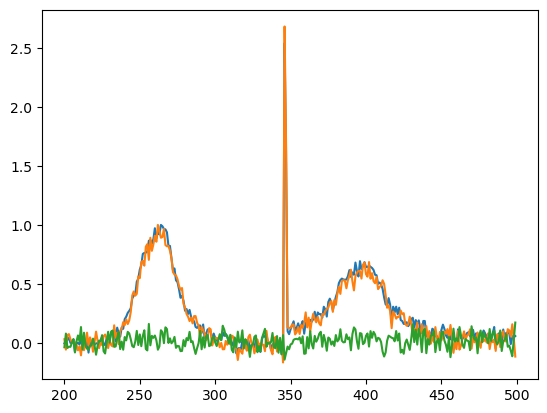

In [21]:
x = np.arange(200, 500, 1, dtype=int)
plt.plot(x,ds1_ROI1_corr_n[200:500])
plt.plot(x,ds2_ROI1_corr_n[200:500])
plt.plot(x,diff_ROI1[200:500])


Smoothing of background corrected data followed by normalization and comparison of smoothed data.

Text(0.5, 1.0, 'Smoothed dataset 1')

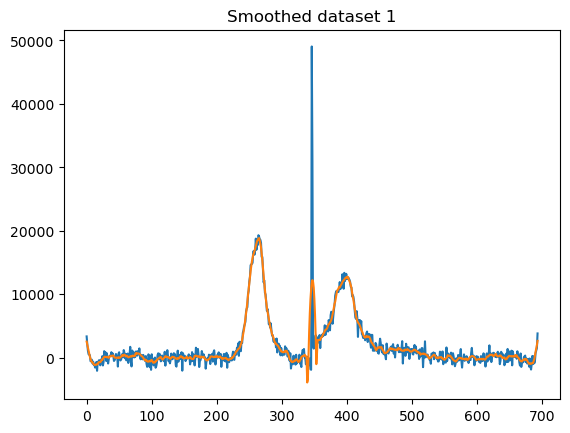

In [22]:
ds1_ROI1_smooth = signal.savgol_filter(ds1_ROI1_corr, window_length=15, polyorder=3, mode="nearest")
plt.plot(ds1_ROI1_corr)
plt.plot(ds1_ROI1_smooth)
plt.title('Smoothed dataset 1')

Text(0.5, 1.0, 'Smoothed dataset 2')

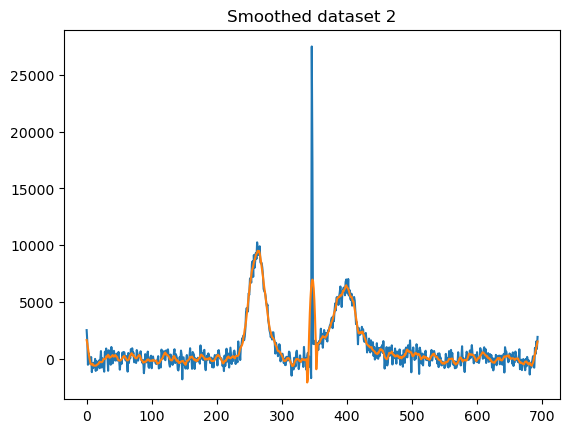

In [23]:
ds2_ROI1_smooth = signal.savgol_filter(ds2_ROI1_corr, window_length=15, polyorder=3, mode="nearest")
plt.plot(ds2_ROI1_corr)
plt.plot(ds2_ROI1_smooth)
plt.title('Smoothed dataset 2')

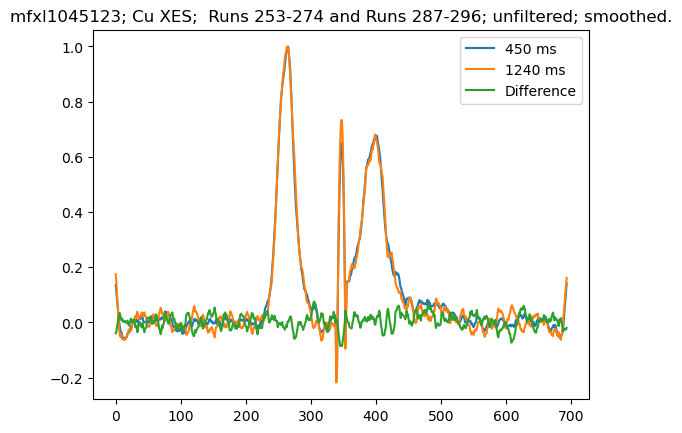

In [24]:
ds1_ROI1_smooth_n = ds1_ROI1_smooth/np.max(ds1_ROI1_smooth[200:300])
ds2_ROI1_smooth_n = ds2_ROI1_smooth/np.max(ds2_ROI1_smooth[200:300])
plt.plot(ds1_ROI1_smooth_n)
plt.plot(ds2_ROI1_smooth_n)

diff_ROI1_smooth = ds1_ROI1_smooth_n-ds2_ROI1_smooth_n
plt.plot(diff_ROI1_smooth)
plt.title('mfxl1045123; Cu XES;  Runs 253-274 and Runs 287-296; unfiltered; smoothed.')
plt.legend(['450 ms','1240 ms','Difference'])

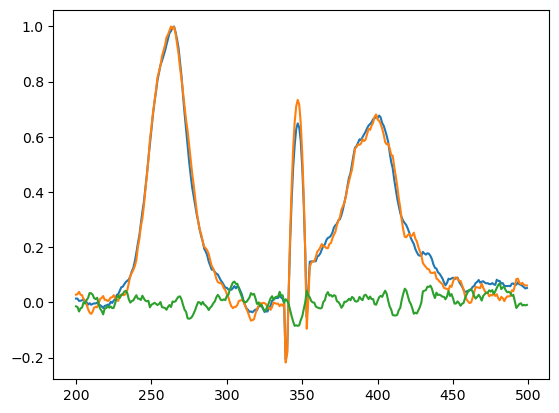

In [25]:
x = np.arange(200, 500, 1, dtype=int)
plt.plot(x,ds1_ROI1_smooth_n[200:500])
plt.plot(x,ds2_ROI1_smooth_n[200:500])



plt.plot(x,diff_ROI1_smooth[200:500])

###Fe ROI's Next###

Importing data for Fe ROI's

Processing: 100%|██████████| 106/106 [18:01<00:00, 10.20s/Shot_Batch]


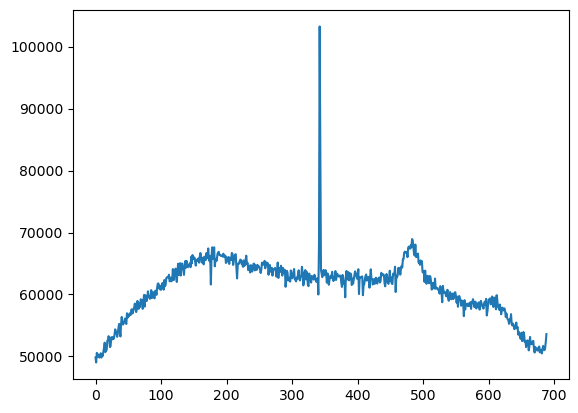

In [81]:
#ds1_ROI2 in this case is the Fe ROI of interest for a particular dataset of runs 253-274 (ds)
xes_experiment = XSpect.XSpect_Analysis.spectroscopy_experiment(hutch='mfx',experiment_id='mfxl1045123',lcls_run=23)
xes=XSpect.XSpect_Controller.XESBatchAnalysisRotation()
xes.key_epix=['epix_1/ROI_0_area']
#xes.set_key_aliases(keys,names)
#xes.import_roi=[[0,100]]
xes.rois=[[25,55]]
xes.adu_cutoff=3.0
xes.angle=-2
xes.transpose=True
xes.run_parser(['253-274'])
#xes.append_arbitrary_filtering(xes_experiment,basepath='filter_indices')
#xes.arbitrary_filter=True
xes.verbose=False

start=time.time()
xes.primary_analysis_parallel_range(4,xes_experiment,method=xes.primary_analysis_static,increment=2000,verbose=False)
end=time.time()
v=XSpect.XSpect_Visualization.XESVisualization()
v.combine_static_spectra(xes_analysis=xes,xes_key='epix_ROI_1_summed')
v.summed_xes=v.summed_xes[10:-10]
plt.plot(v.summed_xes)
ds1_ROI2=v.summed_xes

Processing: 100%|██████████| 66/66 [11:46<00:00, 10.70s/Shot_Batch]


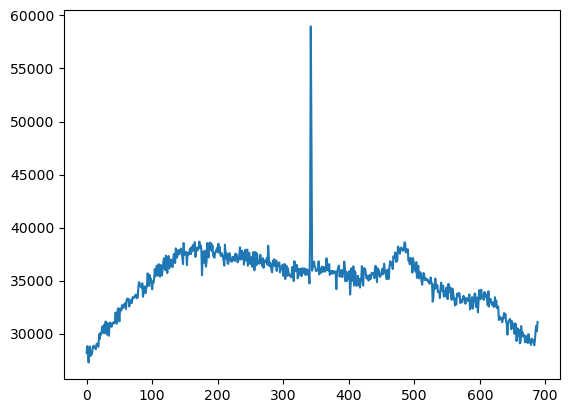

In [82]:
xes_experiment = XSpect.XSpect_Analysis.spectroscopy_experiment(hutch='mfx',experiment_id='mfxl1045123',lcls_run=23)
xes=XSpect.XSpect_Controller.XESBatchAnalysisRotation()
xes.key_epix=['epix_1/ROI_0_area']
#xes.set_key_aliases(keys,names)
#xes.import_roi=[[0,100]]
xes.rois=[[25,55]]
xes.adu_cutoff=3.0
xes.angle=-2
xes.transpose=True
xes.run_parser(['287-300'])
#xes.append_arbitrary_filtering(xes_experiment,basepath='filter_indices')
#xes.arbitrary_filter=True
xes.verbose=False

start=time.time()
xes.primary_analysis_parallel_range(4,xes_experiment,method=xes.primary_analysis_static,increment=2000,verbose=False)
end=time.time()
v=XSpect.XSpect_Visualization.XESVisualization()
v.combine_static_spectra(xes_analysis=xes,xes_key='epix_ROI_1_summed')
v.summed_xes=v.summed_xes[10:-10]
plt.plot(v.summed_xes)
ds2_ROI2=v.summed_xes

Background correction

Text(0.5, 1.0, 'mfxl1045123; Runs 253-274; Fe-background sub, O2reaction 450 ms; Unfiltered.')

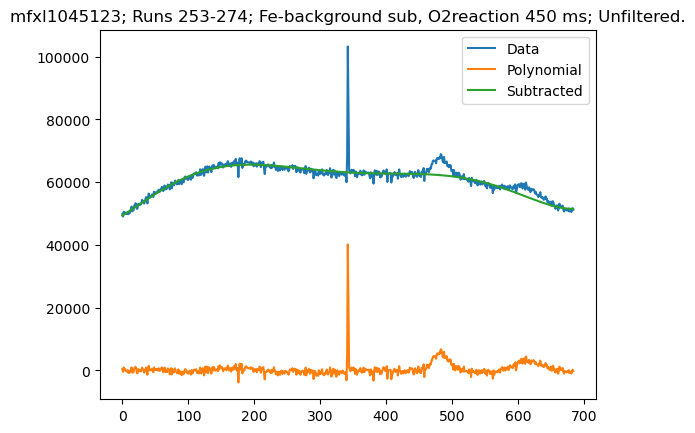

In [147]:
x = np.arange(0, 685, 1, dtype=int)
ds1_ROI2_corr,ds1_ROI2_fit=fit_and_subtract_polynomial(ds1_ROI2,6,[(455,650)])
plt.plot(ds1_ROI2[0:685])
plt.plot(ds1_ROI2_corr[0:685])
plt.plot(ds1_ROI2_fit[0:685])
plt.legend(['Data','Polynomial','Subtracted'])
plt.title('mfxl1045123; Runs 253-274; Fe-background sub, O2reaction 450 ms; Unfiltered.')

Text(0.5, 1.0, 'mfxl1045123; Runs 287-296; Fe-background sub, o2reaction_5mm; Unfiltered.')

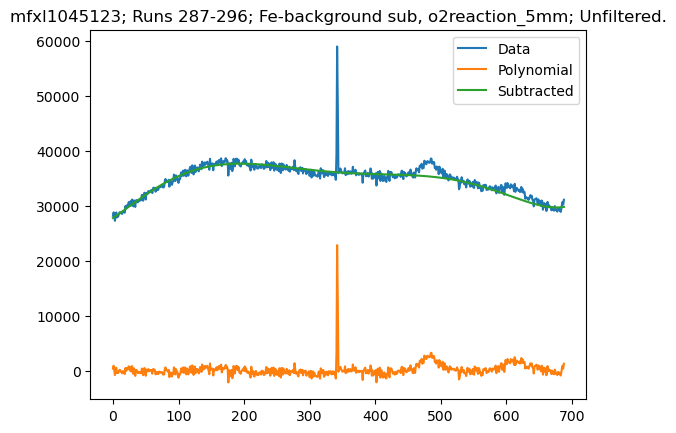

In [148]:
ds2_ROI2_corr,ds2_ROI2_fit=fit_and_subtract_polynomial(ds2_ROI2,6,[(455,650)])
plt.plot(ds2_ROI2)
plt.plot(ds2_ROI2_corr)
plt.plot(ds2_ROI2_fit)
plt.legend(['Data','Polynomial','Subtracted'])
plt.title('mfxl1045123; Runs 287-296; Fe-background sub, o2reaction_5mm; Unfiltered.')

Normalization of background corrected data

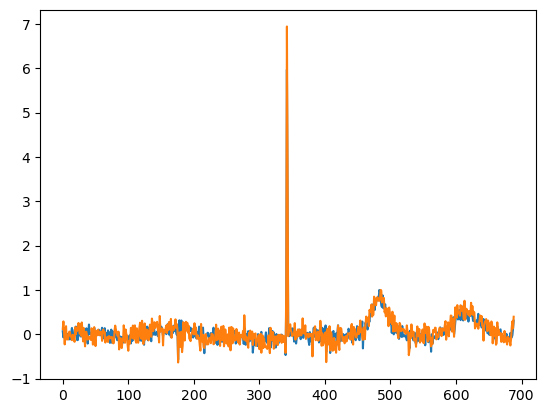

In [149]:

ds1_ROI2_corr_n = ds1_ROI2_corr/np.max(ds1_ROI2_corr[450:520])
ds2_ROI2_corr_n = ds2_ROI2_corr/np.max(ds2_ROI2_corr[450:520])
plt.plot(ds1_ROI2_corr_n)
plt.plot(ds2_ROI2_corr_n)

Comparison background corrected normalized data of different scans

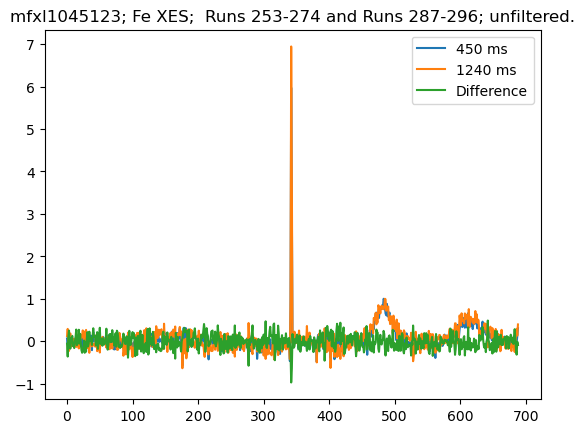

In [150]:
plt.plot(ds1_ROI2_corr_n)
plt.plot(ds2_ROI2_corr_n)

diff_ROI2 = ds1_ROI2_corr_n-ds2_ROI2_corr_n
plt.plot(diff_ROI2)
plt.title('mfxl1045123; Fe XES;  Runs 253-274 and Runs 287-296; unfiltered.')
plt.legend(['450 ms','1240 ms','Difference'])


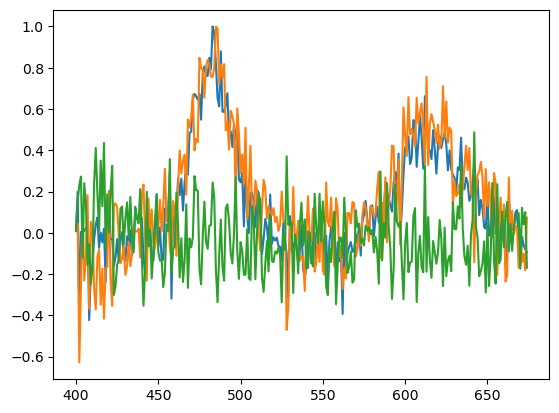

In [151]:
x = np.arange(400, 675, 1, dtype=int)
plt.plot(x,ds1_ROI2_corr_n[400:675])
plt.plot(x,ds2_ROI2_corr_n[400:675])
plt.plot(x,diff_ROI2[400:675])


Smoothing of background corrected data followed by normalization and comparison of smoothed data.

Text(0.5, 1.0, 'Smoothed dataset 1')

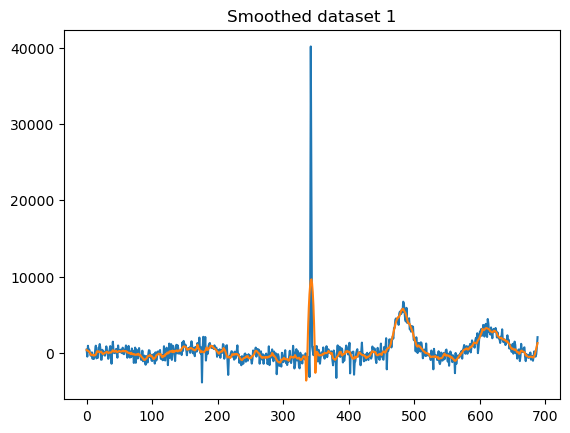

In [152]:
ds1_ROI2_smooth = signal.savgol_filter(ds1_ROI2_corr, window_length=15, polyorder=3, mode="nearest")
plt.plot(ds1_ROI2_corr)
plt.plot(ds1_ROI2_smooth)
plt.title('Smoothed dataset 1')

Text(0.5, 1.0, 'Smoothed dataset 2')

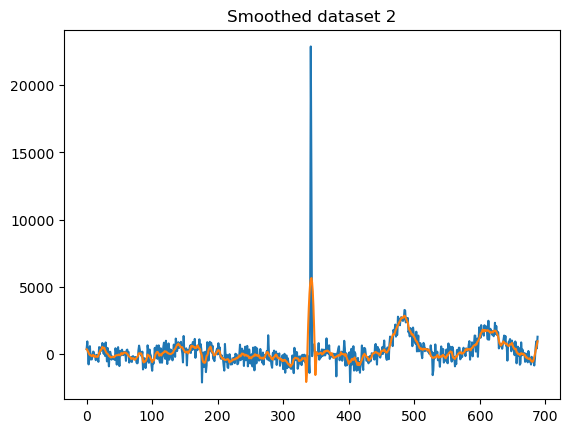

In [153]:
ds2_ROI2_smooth = signal.savgol_filter(ds2_ROI2_corr, window_length=15, polyorder=3, mode="nearest")
plt.plot(ds2_ROI2_corr)
plt.plot(ds2_ROI2_smooth)
plt.title('Smoothed dataset 2')

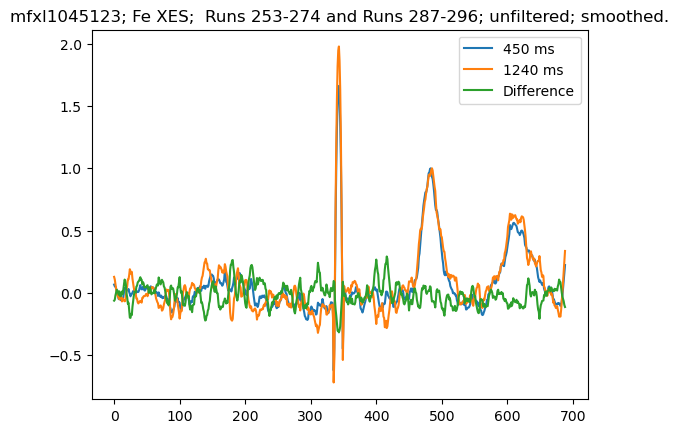

In [154]:
ds1_ROI2_smooth_n = ds1_ROI2_smooth/np.max(ds1_ROI2_smooth[450:520])
ds2_ROI2_smooth_n = ds2_ROI2_smooth/np.max(ds2_ROI2_smooth[450:520])
plt.plot(ds1_ROI2_smooth_n)
plt.plot(ds2_ROI2_smooth_n)

diff_ROI2_smooth = ds1_ROI2_smooth_n-ds2_ROI2_smooth_n
plt.plot(diff_ROI2_smooth)
plt.title('mfxl1045123; Fe XES;  Runs 253-274 and Runs 287-296; unfiltered; smoothed.')
plt.legend(['450 ms','1240 ms','Difference'])

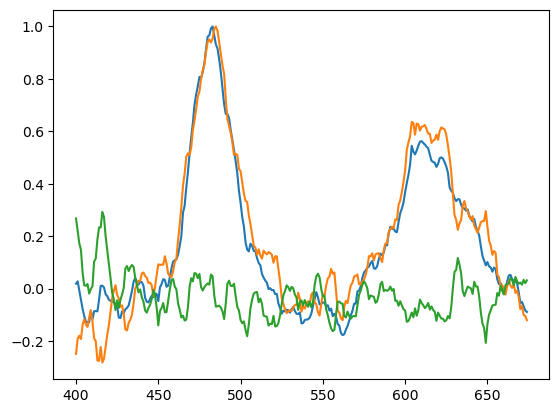

In [155]:
x = np.arange(400, 675, 1, dtype=int)
plt.plot(x,ds1_ROI2_smooth_n[400:675])
plt.plot(x,ds2_ROI2_smooth_n[400:675])



plt.plot(x,diff_ROI2_smooth[400:675])

##Testing things here##

Text(0.5, 1.0, 'mfxl1045123; Runs 253-274; Fe-background sub, O2reaction 450 ms; Unfiltered.')

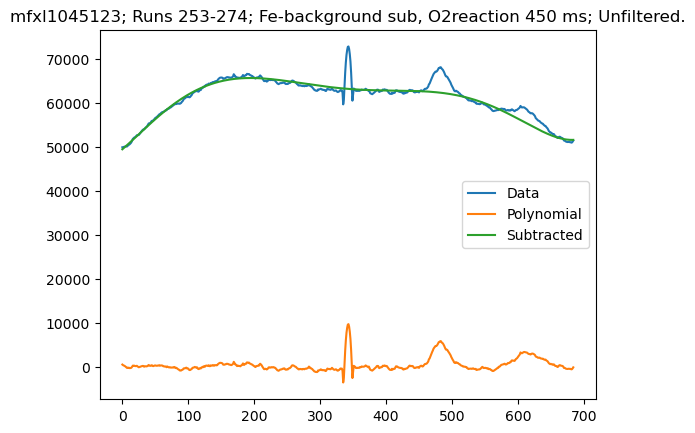

In [144]:
x = np.arange(0, 685, 1, dtype=int)
ds1_ROI2_smooth = signal.savgol_filter(ds1_ROI2, window_length=15, polyorder=3, mode="nearest")
ds1_ROI2_corr_s,ds1_ROI2_s_fit=fit_and_subtract_polynomial(ds1_ROI2_smooth,6,[(455,650)])
plt.plot(ds1_ROI2_smooth[0:685])
plt.plot(ds1_ROI2_corr_s[0:685])
plt.plot(ds1_ROI2_s_fit[0:685])
plt.legend(['Data','Polynomial','Subtracted'])
plt.title('mfxl1045123; Runs 253-274; Fe-background sub, O2reaction 450 ms; Unfiltered.')

Text(0.5, 1.0, 'mfxl1045123; Runs 253-274; Fe-background sub, O2reaction 450 ms; Unfiltered.')

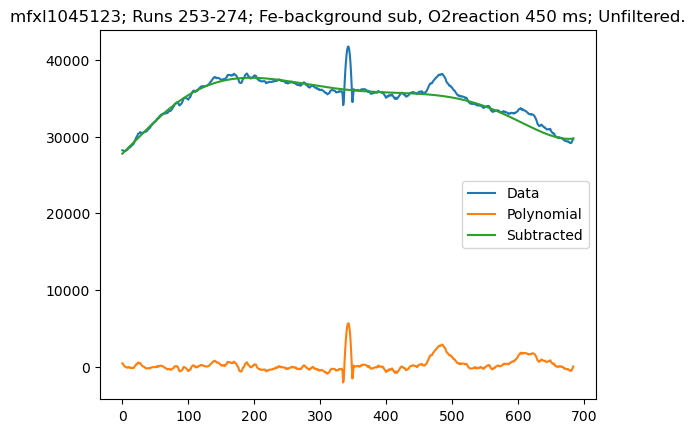

In [145]:
x = np.arange(0, 685, 1, dtype=int)
ds2_ROI2_smooth = signal.savgol_filter(ds2_ROI2, window_length=15, polyorder=3, mode="nearest")
ds2_ROI2_corr_s,ds2_ROI2_s_fit=fit_and_subtract_polynomial(ds2_ROI2_smooth,6,[(455,650)])
plt.plot(ds2_ROI2_smooth[0:685])
plt.plot(ds2_ROI2_corr_s[0:685])
plt.plot(ds2_ROI2_s_fit[0:685])
plt.legend(['Data','Polynomial','Subtracted'])
plt.title('mfxl1045123; Runs 253-274; Fe-background sub, O2reaction 450 ms; Unfiltered.')

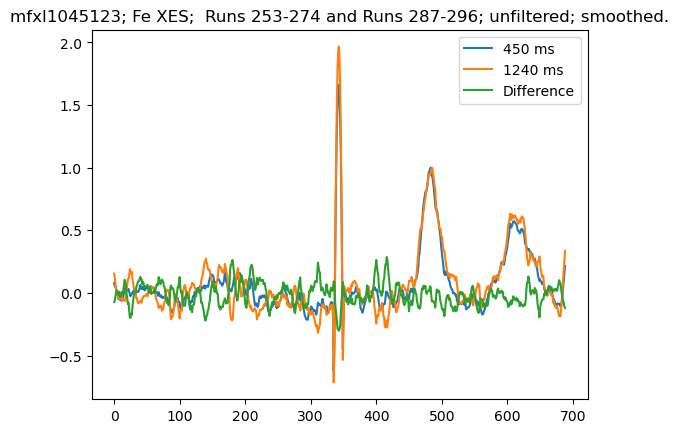

In [146]:
ds1_ROI2_smooth_n = ds1_ROI2_corr_s/np.max(ds1_ROI2_corr_s[450:520])
ds2_ROI2_smooth_n = ds2_ROI2_corr_s/np.max(ds2_ROI2_corr_s[450:520])
plt.plot(ds1_ROI2_smooth_n)
plt.plot(ds2_ROI2_smooth_n)

diff_ROI2_smooth = ds1_ROI2_smooth_n-ds2_ROI2_smooth_n
plt.plot(diff_ROI2_smooth)
plt.title('mfxl1045123; Fe XES;  Runs 253-274 and Runs 287-296; unfiltered; smoothed.')
plt.legend(['450 ms','1240 ms','Difference'])

##Both Fe and Cu spectrums.##

In [36]:
#plt.title('mfxl1045123; Runs 32-60; Oxidized Cytochrome c; Crystal shot filtered.')
#plt.plot(ds1_ROI1_corr)
#plt.plot(ds1_ROI2_corr)
#plt.legend(['Cu Ka','Fe Ka'])
#plt.xlabel('Pixel Number (arb)')
#plt.ylabel('Intensity')


In [37]:
#plt.title('mfxl1045123; Runs 61-94; Reduced Cytochrome c; Crystal shot filtered.')
#plt.plot(ds1_ROI1_corr)
#plt.plot(ds1_ROI2_corr)
#plt.legend(['Cu Ka','Fe Ka'])
#plt.xlabel('Pixel Number (arb)')
#plt.ylabel('Intensity')

In [38]:
#plt.plot(diff_Fe)

In [39]:
#plt.plot(diff_Cu_smooth[185:500])
#plt.plot(diff_Fe_smooth[400:675])
#plt.legend(['diff_Cu_smooth','diff_Fe_smooth'])

In [40]:
#np.max(reduced_Fe_corr[450:675])